# Predicting Antibody Binding from Amino Acid Sequences

## Initial Setup and Data Exploration

This notebook focuses on exploring the AVIDa-SARS-CoV-2 dataset to understand its characteristics and prepare for feature engineering.

## 1. Import Libraries

In [17]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

# Bio-specific libraries
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
from Bio.Seq import Seq

# File handling
import os
import sys
import warnings

# Progress bar
from tqdm.notebook import tqdm

# Set plot style
sns.set_style("whitegrid")
sns.set_palette('viridis')

# Ignore warnings
warnings.filterwarnings('ignore')

## 2. Dataset Source and Citation

The AVIDa-SARS-CoV-2 dataset is a comprehensive collection of antibody sequences with binding information to SARS-CoV-2 variants. This dataset was published as part of research in computational immunology and machine learning for antibody design.

### Citation

```
Ruffolo, J.A., Gray, A.N., Sulam, J. et al. Antibody structure prediction using interpretable deep learning. Patterns 3, 100570 (2022). https://doi.org/10.1016/j.patter.2022.100570
```

### Dataset Description

- **Source**: The dataset is available through Hugging Face at https://huggingface.co/datasets/COGNANO/AVIDa-SARS-CoV-2
- **Content**: 77,003 full-length VHH (alpaca) antibody sequences
  - 22,002 binders (label=1)
  - 55,001 non-binders (label=0)
- **Antigens**: 12 SARS-CoV-2 variants (e.g., WT, Delta, Omicron)
- **Metadata**: Includes antigen label, species (alpaca), donor ID, and sex

The dataset was generated through high-throughput screening of antibody libraries against SARS-CoV-2 variants. The binding/non-binding labels were determined experimentally through display technologies that measure antibody-antigen interactions.

## 3. Define Paths and Load Data

In [18]:
# Define paths
DATA_RAW_DIR = '../data/raw'
DATA_PROCESSED_DIR = '../data/processed'
RESULTS_DIR = '../results'
FIGURES_DIR = '../results/figures'

# Create directories if they don't exist
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

### 3.1 Data Loading Functions

In [19]:
def load_dataset(split='all'):
    """
    Load the AVIDa-SARS-CoV-2 dataset from CSV files.
    
    Parameters:
    -----------
    split : str, default='all'
        Which split to load: 'train', 'test', or 'all'
        
    Returns:
    --------
    pandas.DataFrame or dict of pandas.DataFrame
        The loaded dataset(s)
    """
    if split == 'train':
        train_path = os.path.join(DATA_RAW_DIR, 'train.csv')
        if not os.path.exists(train_path):
            raise FileNotFoundError(f"Training data file not found at {train_path}")
        return pd.read_csv(train_path)
    
    elif split == 'test':
        test_path = os.path.join(DATA_RAW_DIR, 'test.csv')
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"Test data file not found at {test_path}")
        return pd.read_csv(test_path)
    
    elif split == 'all':
        # Load both train and test data
        train_path = os.path.join(DATA_RAW_DIR, 'train.csv')
        test_path = os.path.join(DATA_RAW_DIR, 'test.csv')
        
        if not os.path.exists(train_path) or not os.path.exists(test_path):
            # Try loading the combined data file
            data_path = os.path.join(DATA_RAW_DIR, 'data.csv')
            if os.path.exists(data_path):
                return pd.read_csv(data_path)
            else:
                raise FileNotFoundError(f"Data files not found at {DATA_RAW_DIR}")
        
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        
        return {
            'train': train_df,
            'test': test_df,
            'combined': pd.concat([train_df, test_df], ignore_index=True)
        }
    
    else:
        raise ValueError("split must be one of 'train', 'test', or 'all'")

def verify_data_integrity(data):
    """
    Verify the integrity and structure of the loaded dataset.
    
    Parameters:
    -----------
    data : pandas.DataFrame or dict of pandas.DataFrame
        The dataset to verify
        
    Returns:
    --------
    bool
        True if the data passes all integrity checks, False otherwise
    """
    if isinstance(data, dict):
        # Check each split separately
        results = []
        for split_name, df in data.items():
            print(f"Verifying {split_name} split...")
            results.append(_verify_dataframe(df))
        return all(results)
    else:
        # Check the single dataframe
        return _verify_dataframe(data)

def _verify_dataframe(df):
    """
    Helper function to verify a single dataframe.
    """
    # Check required columns
    required_columns = ['VHH_sequence', 'Ag_label', 'label', 'subject_species', 'subject_name', 'subject_sex']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Error: Missing columns: {missing_columns}")
        return False
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Warning: Dataset contains missing values:")
        print(missing_values[missing_values > 0])
    
    # Check sequence validity (all sequences should contain only valid amino acid codes)
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
    invalid_sequences = df[~df['VHH_sequence'].apply(lambda seq: set(seq).issubset(valid_aa))]
    
    if len(invalid_sequences) > 0:
        print(f"Warning: Found {len(invalid_sequences)} sequences with invalid amino acid codes")
    
    # Check label values (should be binary: 0 or 1)
    unique_labels = df['label'].unique()
    if not set(unique_labels).issubset({0, 1}):
        print(f"Error: Invalid label values found: {unique_labels}")
        return False
    
    # Check if there are enough samples of each class
    class_counts = df['label'].value_counts()
    if len(class_counts) < 2 or min(class_counts) < 10:
        print("Warning: Imbalanced dataset or too few samples in one class")
        print(class_counts)
    
    print("Data verification completed successfully.")
    return True

### 3.2 Load and Verify Dataset

In [20]:
# Load the dataset
print("Loading AVIDa-SARS-CoV-2 dataset...")
data = load_dataset('all')

# Verify data integrity
verify_data_integrity(data)

Loading AVIDa-SARS-CoV-2 dataset...
Verifying train split...
Data verification completed successfully.
Verifying test split...
Data verification completed successfully.
Verifying combined split...
Data verification completed successfully.


True

### 3.3 Dataset Overview

In [21]:
def print_dataset_overview(data):
    """
    Print an overview of the dataset.
    """
    if isinstance(data, dict):
        # Print overview for each split
        print("Dataset Overview:")
        print("-" * 50)
        
        for split_name, df in data.items():
            print(f"\n{split_name.capitalize()} Split:")
            print(f"  - Samples: {len(df)}")
            print(f"  - Features: {df.shape[1]}")
            print(f"  - Class distribution: {df['label'].value_counts().to_dict()}")
            print(f"  - Class balance ratio: {df['label'].value_counts()[0] / df['label'].value_counts()[1]:.2f}:1 (non-binders:binders)")
            print(f"  - Unique antigen variants: {df['Ag_label'].nunique()}")
            print(f"  - Unique donors: {df['subject_name'].nunique()}")
    else:
        # Print overview for single dataframe
        print("Dataset Overview:")
        print("-" * 50)
        print(f"Samples: {len(data)}")
        print(f"Features: {data.shape[1]}")
        print(f"Class distribution: {data['label'].value_counts().to_dict()}")
        print(f"Class balance ratio: {data['label'].value_counts()[0] / data['label'].value_counts()[1]:.2f}:1 (non-binders:binders)")
        print(f"Unique antigen variants: {data['Ag_label'].nunique()}")
        print(f"Unique donors: {data['subject_name'].nunique()}")

# Print dataset overview
print_dataset_overview(data)

Dataset Overview:
--------------------------------------------------

Train Split:
  - Samples: 49685
  - Features: 6
  - Class distribution: {0: 34285, 1: 15400}
  - Class balance ratio: 2.23:1 (non-binders:binders)
  - Unique antigen variants: 17
  - Unique donors: 1

Test Split:
  - Samples: 27318
  - Features: 6
  - Class distribution: {0: 20716, 1: 6602}
  - Class balance ratio: 3.14:1 (non-binders:binders)
  - Unique antigen variants: 12
  - Unique donors: 1

Combined Split:
  - Samples: 77003
  - Features: 6
  - Class distribution: {0: 55001, 1: 22002}
  - Class balance ratio: 2.50:1 (non-binders:binders)
  - Unique antigen variants: 17
  - Unique donors: 2


## 4. Initial Exploratory Data Analysis

Now we'll perform initial exploratory data analysis to understand the characteristics of the dataset.

### 4.1 Sequence Length Distribution

Analyzing the distribution of sequence lengths is important because:
1. It helps identify potential outliers or truncated sequences
2. Sequence length can be a feature that correlates with binding properties
3. It informs preprocessing decisions (e.g., padding or truncation for ML models)

Sequence Length Statistics:
count    77003.000000
mean       145.810890
std          4.631343
min         94.000000
25%        143.000000
50%        147.000000
75%        149.000000
max        166.000000
Name: seq_length, dtype: float64


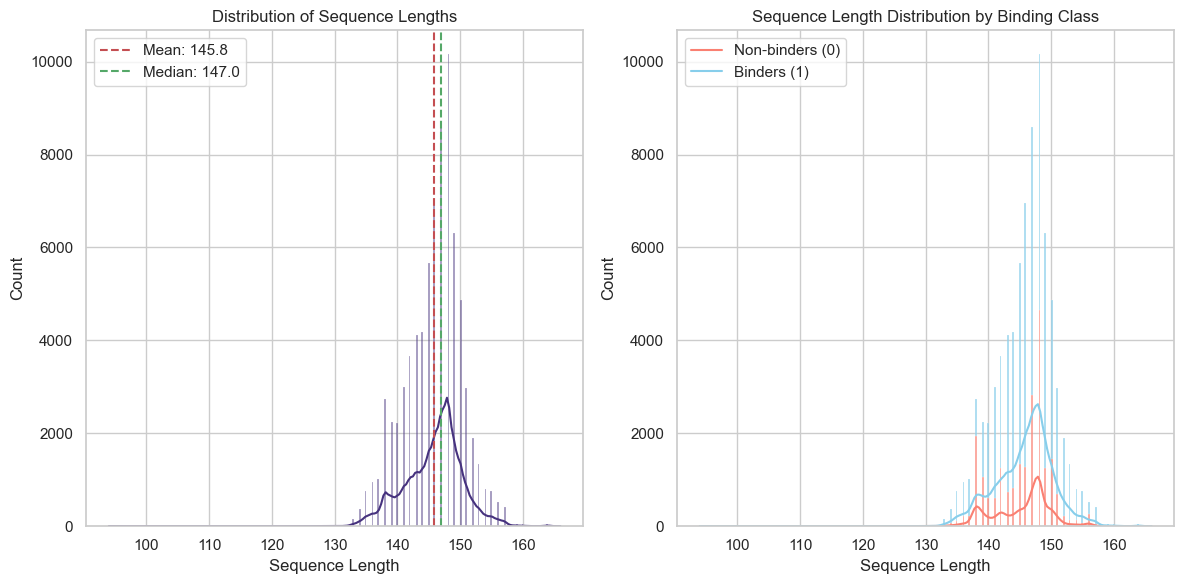


T-test for sequence length difference between binders and non-binders:
t-statistic: -17.4793
p-value: 0.0000
Mean length for binders: 145.36
Mean length for non-binders: 145.99
There is a statistically significant difference in sequence lengths between binders and non-binders.


In [22]:
def analyze_sequence_length(data):
    """
    Analyze and visualize the distribution of sequence lengths.
    """
    if isinstance(data, dict):
        df = data['combined']
    else:
        df = data
    
    # Calculate sequence lengths
    df['seq_length'] = df['VHH_sequence'].apply(len)
    
    # Calculate statistics
    length_stats = df['seq_length'].describe()
    print("Sequence Length Statistics:")
    print(length_stats)
    
    # Plot histogram of sequence lengths
    plt.figure(figsize=(12, 6))
    
    # Overall distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['seq_length'], kde=True)
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.axvline(length_stats['mean'], color='r', linestyle='--', label=f"Mean: {length_stats['mean']:.1f}")
    plt.axvline(length_stats['50%'], color='g', linestyle='--', label=f"Median: {length_stats['50%']:.1f}")
    plt.legend()
    
    # Distribution by binding class
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='seq_length', hue='label', kde=True, palette=['skyblue', 'salmon'], 
                 multiple='stack', hue_order=[0, 1], alpha=0.7)
    plt.title('Sequence Length Distribution by Binding Class')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.legend(['Non-binders (0)', 'Binders (1)'])
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'sequence_length_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical test to see if sequence length differs between binders and non-binders
    binders = df[df['label'] == 1]['seq_length']
    non_binders = df[df['label'] == 0]['seq_length']
    
    t_stat, p_value = stats.ttest_ind(binders, non_binders, equal_var=False)
    print(f"\nT-test for sequence length difference between binders and non-binders:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Mean length for binders: {binders.mean():.2f}")
    print(f"Mean length for non-binders: {non_binders.mean():.2f}")
    
    if p_value < 0.05:
        print("There is a statistically significant difference in sequence lengths between binders and non-binders.")
    else:
        print("There is no statistically significant difference in sequence lengths between binders and non-binders.")
    
    return df

# Analyze sequence length distribution
df_with_length = analyze_sequence_length(data)

### 4.2 Class Distribution Analysis

Understanding the class distribution is crucial because:
1. It reveals potential class imbalance that may affect model training
2. It helps in designing appropriate sampling or weighting strategies
3. It provides context for interpreting model performance metrics

Class Distribution:
Non-binders (0): 55001 samples (71.43%)
Binders (1): 22002 samples (28.57%)
Ratio (non-binders:binders): 2.50:1


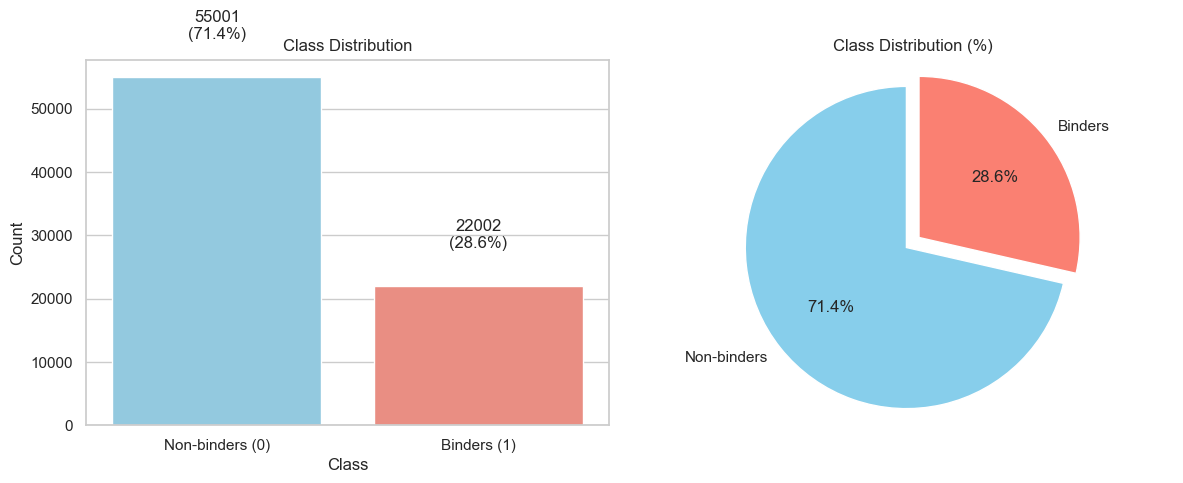

In [23]:
def analyze_class_distribution(data):
    """
    Analyze and visualize the distribution of binding classes.
    """
    if isinstance(data, dict):
        df = data['combined']
    else:
        df = data
    
    # Calculate class distribution
    class_counts = df['label'].value_counts().sort_index()
    class_percentages = 100 * class_counts / len(df)
    
    print("Class Distribution:")
    print(f"Non-binders (0): {class_counts[0]} samples ({class_percentages[0]:.2f}%)")
    print(f"Binders (1): {class_counts[1]} samples ({class_percentages[1]:.2f}%)")
    print(f"Ratio (non-binders:binders): {class_counts[0]/class_counts[1]:.2f}:1")
    
    # Plot class distribution
    plt.figure(figsize=(12, 5))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(x=class_counts.index, y=class_counts.values, palette=['skyblue', 'salmon'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-binders (0)', 'Binders (1)'])
    
    for i, count in enumerate(class_counts):
        plt.text(i, count + 0.1 * max(class_counts), f"{count}\n({class_percentages[i]:.1f}%)", 
                 ha='center', va='bottom')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(class_counts, labels=['Non-binders', 'Binders'], autopct='%1.1f%%', 
            colors=['skyblue', 'salmon'], startangle=90, explode=[0, 0.1])
    plt.title('Class Distribution (%)')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Analyze class distribution
analyze_class_distribution(data)

### 4.3 Antigen Variant Distribution

Analyzing the distribution across antigen variants is important because:
1. It reveals which SARS-CoV-2 variants are represented in the dataset
2. It helps identify potential biases in variant representation
3. It allows for stratified analysis of binding properties across variants

Antigen Variant Distribution:
WT_cell: 10790 samples (14.01%)
D614G_cell: 8436 samples (10.96%)
Beta_cell: 6113 samples (7.94%)
S2-domain_bead: 5475 samples (7.11%)
Alpha+K417N_cell: 5167 samples (6.71%)
Alpha+E484K_cell: 4800 samples (6.23%)
Omicron_cell: 4664 samples (6.06%)
Lambda_bead: 4054 samples (5.26%)
Delta_cell: 3917 samples (5.09%)
Alpha_cell: 3908 samples (5.08%)
OC43_bead: 3733 samples (4.85%)
Omicron_bead: 3291 samples (4.27%)
Beta_bead: 3201 samples (4.16%)
PMS_bead: 2905 samples (3.77%)
Kappa_bead: 2652 samples (3.44%)
Delta_bead: 1969 samples (2.56%)
Alpha_bead: 1928 samples (2.50%)


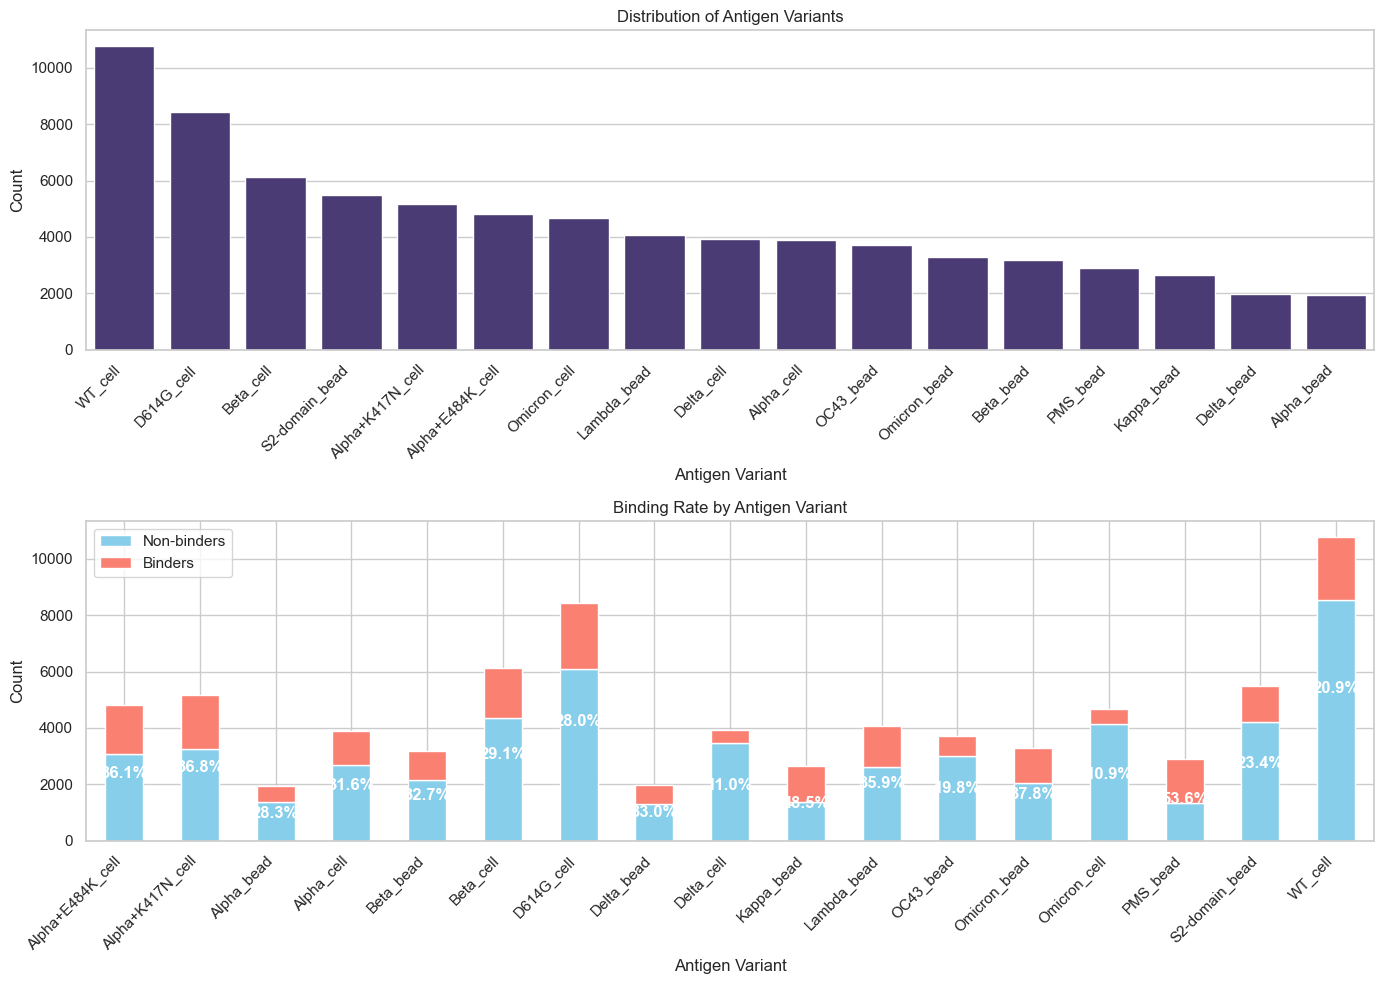

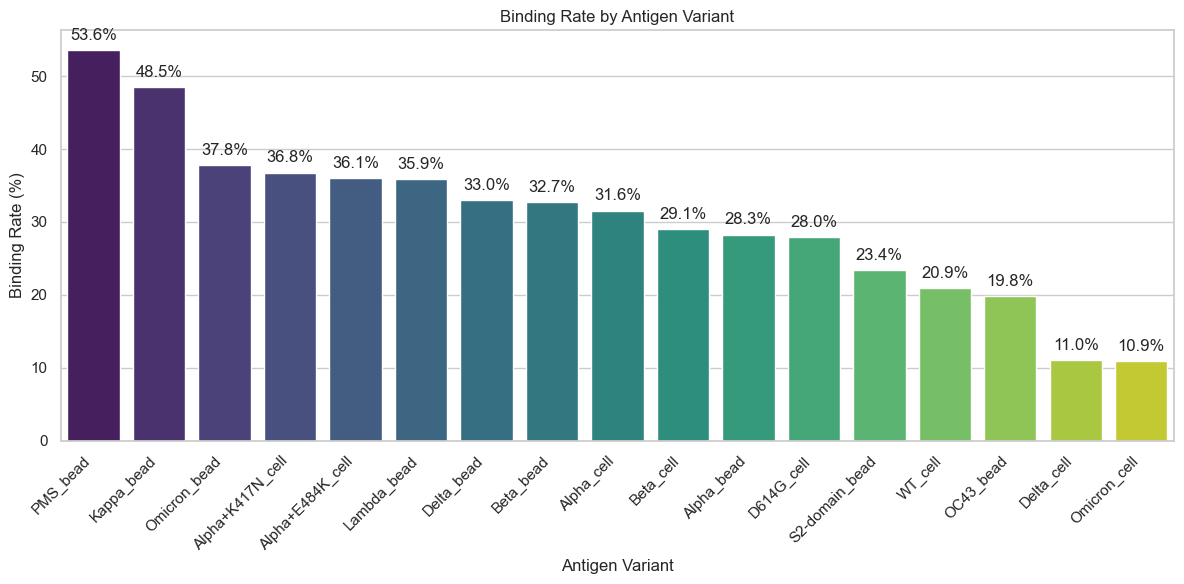

In [24]:
def analyze_antigen_variants(data):
    """
    Analyze and visualize the distribution of antigen variants.
    """
    if isinstance(data, dict):
        df = data['combined']
    else:
        df = data
    
    # Calculate variant distribution
    variant_counts = df['Ag_label'].value_counts()
    
    print("Antigen Variant Distribution:")
    for variant, count in variant_counts.items():
        print(f"{variant}: {count} samples ({100 * count / len(df):.2f}%)")
    
    # Plot variant distribution
    plt.figure(figsize=(14, 10))
    
    # Overall distribution
    plt.subplot(2, 1, 1)
    sns.barplot(x=variant_counts.index, y=variant_counts.values)
    plt.title('Distribution of Antigen Variants')
    plt.xlabel('Antigen Variant')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Distribution by binding class
    plt.subplot(2, 1, 2)
    variant_binding = pd.crosstab(df['Ag_label'], df['label'])
    variant_binding.columns = ['Non-binders', 'Binders']
    variant_binding_pct = variant_binding.div(variant_binding.sum(axis=1), axis=0) * 100
    
    variant_binding.plot(kind='bar', stacked=True, ax=plt.gca(), color=['skyblue', 'salmon'])
    plt.title('Binding Rate by Antigen Variant')
    plt.xlabel('Antigen Variant')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage labels
    for i, variant in enumerate(variant_binding.index):
        non_binders = variant_binding.loc[variant, 'Non-binders']
        binders = variant_binding.loc[variant, 'Binders']
        total = non_binders + binders
        plt.text(i, total/2, f"{variant_binding_pct.loc[variant, 'Binders']:.1f}%", 
                 ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'antigen_variant_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a separate plot for binding rate by variant
    plt.figure(figsize=(12, 6))
    binding_rate = variant_binding_pct['Binders'].sort_values(ascending=False)
    
    sns.barplot(x=binding_rate.index, y=binding_rate.values, palette='viridis')
    plt.title('Binding Rate by Antigen Variant')
    plt.xlabel('Antigen Variant')
    plt.ylabel('Binding Rate (%)')
    plt.xticks(rotation=45, ha='right')
    
    for i, rate in enumerate(binding_rate):
        plt.text(i, rate + 1, f"{rate:.1f}%", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'binding_rate_by_variant.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Analyze antigen variant distribution
analyze_antigen_variants(data)

### 4.4 Metadata Analysis (Species, Donor ID, Sex)

Analyzing metadata is important because:
1. It helps identify potential biases in the dataset
2. It allows for stratified analysis of binding properties across different donors
3. It provides context for interpreting model performance and generalizability

Species Distribution:
alpaca: 77003 samples (100.00%)

Donor Distribution:
puta: 49685 samples (64.52%)
christy: 27318 samples (35.48%)

Sex Distribution:
male: 49685 samples (64.52%)
female: 27318 samples (35.48%)


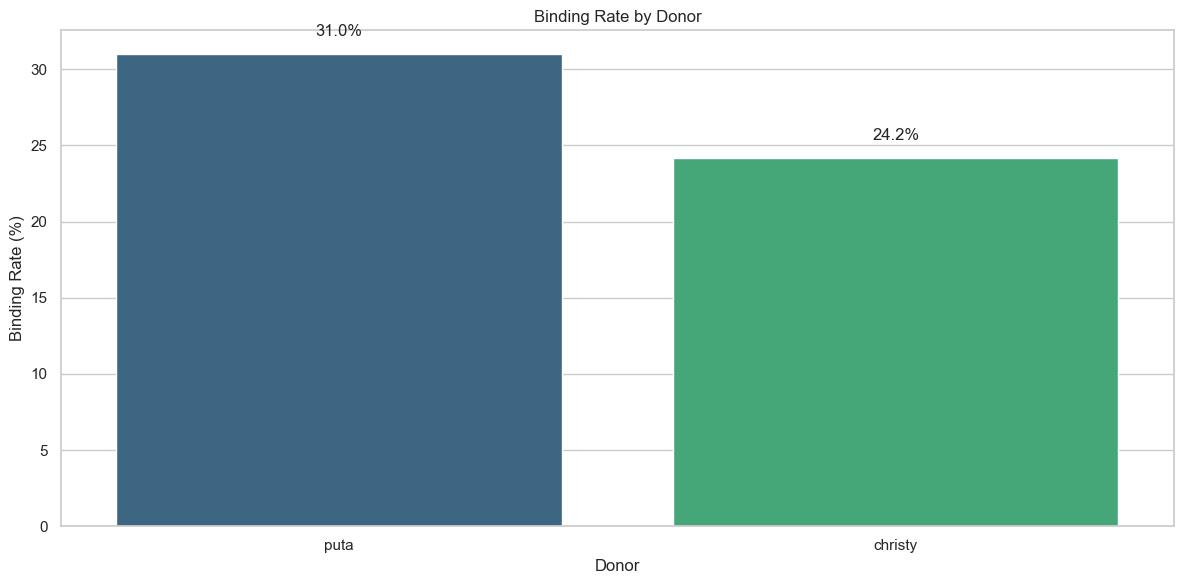


Chi-square test for binding rate difference between sexes:
Chi2 statistic: 402.3297
p-value: 0.0000
There is a statistically significant difference in binding rates between sexes.


In [25]:
def analyze_metadata(data):
    """
    Analyze and visualize the metadata (species, donor ID, sex).
    """
    if isinstance(data, dict):
        df = data['combined']
    else:
        df = data
    
    # Species analysis
    species_counts = df['subject_species'].value_counts()
    print("Species Distribution:")
    for species, count in species_counts.items():
        print(f"{species}: {count} samples ({100 * count / len(df):.2f}%)")
    
    # Donor analysis
    donor_counts = df['subject_name'].value_counts()
    print("\nDonor Distribution:")
    for donor, count in donor_counts.items():
        print(f"{donor}: {count} samples ({100 * count / len(df):.2f}%)")
    
    # Sex analysis
    sex_counts = df['subject_sex'].value_counts()
    print("\nSex Distribution:")
    for sex, count in sex_counts.items():
        print(f"{sex}: {count} samples ({100 * count / len(df):.2f}%)")
    
    # Plot donor distribution with binding rate
    plt.figure(figsize=(12, 6))
    
    # Calculate binding rate by donor
    donor_binding = pd.crosstab(df['subject_name'], df['label'])
    donor_binding.columns = ['Non-binders', 'Binders']
    donor_binding['Total'] = donor_binding.sum(axis=1)
    donor_binding['Binding_Rate'] = 100 * donor_binding['Binders'] / donor_binding['Total']
    donor_binding = donor_binding.sort_values('Binding_Rate', ascending=False)
    
    # Plot binding rate by donor
    sns.barplot(x=donor_binding.index, y=donor_binding['Binding_Rate'], palette='viridis')
    plt.title('Binding Rate by Donor')
    plt.xlabel('Donor')
    plt.ylabel('Binding Rate (%)')
    
    for i, rate in enumerate(donor_binding['Binding_Rate']):
        plt.text(i, rate + 1, f"{rate:.1f}%", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'binding_rate_by_donor.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical test for binding rate difference between sexes
    if len(sex_counts) > 1:
        sex_binding = pd.crosstab(df['subject_sex'], df['label'])
        sex_binding.columns = ['Non-binders', 'Binders']
        
        # Chi-square test
        chi2, p, dof, expected = stats.chi2_contingency(sex_binding)
        print(f"\nChi-square test for binding rate difference between sexes:")
        print(f"Chi2 statistic: {chi2:.4f}")
        print(f"p-value: {p:.4f}")
        
        if p < 0.05:
            print("There is a statistically significant difference in binding rates between sexes.")
        else:
            print("There is no statistically significant difference in binding rates between sexes.")

# Analyze metadata
analyze_metadata(data)

### 4.5 Amino Acid Composition Analysis

Analyzing amino acid composition is important because:
1. Certain amino acids may be more prevalent in binding vs. non-binding antibodies
2. Amino acid composition can be a key feature for predicting binding properties
3. It provides insights into the biochemical properties that influence binding

Sampling 10,000 sequences for amino acid composition analysis...
Calculating amino acid composition...


  0%|          | 0/10000 [00:00<?, ?it/s]

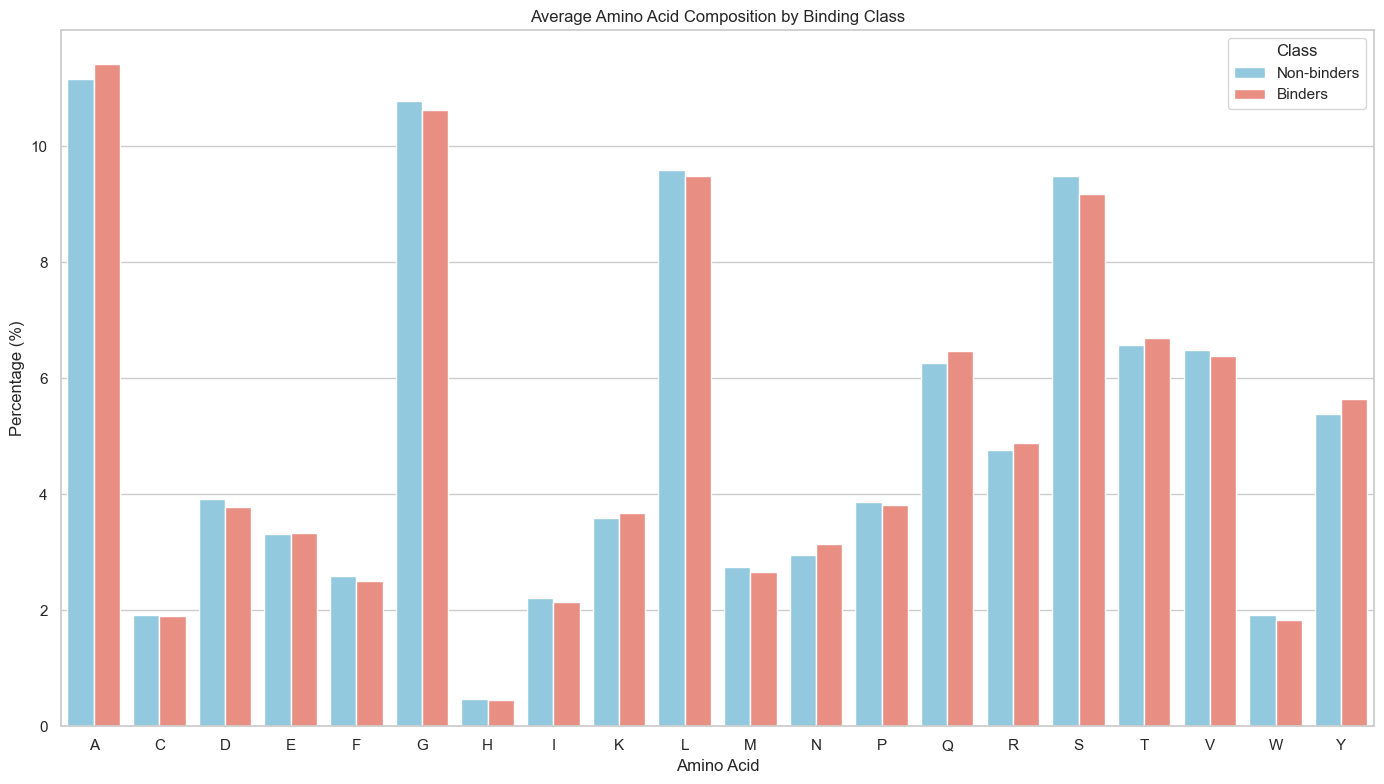


Statistical tests for amino acid composition differences:
A: p-value = 0.0000 *** (Mean in binders: 11.42%, Mean in non-binders: 11.16%)
D: p-value = 0.0000 *** (Mean in binders: 3.79%, Mean in non-binders: 3.93%)
F: p-value = 0.0000 *** (Mean in binders: 2.51%, Mean in non-binders: 2.58%)
G: p-value = 0.0000 *** (Mean in binders: 10.62%, Mean in non-binders: 10.78%)
H: p-value = 0.0139 * (Mean in binders: 0.44%, Mean in non-binders: 0.47%)
I: p-value = 0.0000 *** (Mean in binders: 2.14%, Mean in non-binders: 2.22%)
K: p-value = 0.0000 *** (Mean in binders: 3.68%, Mean in non-binders: 3.59%)
L: p-value = 0.0000 *** (Mean in binders: 9.48%, Mean in non-binders: 9.59%)
M: p-value = 0.0000 *** (Mean in binders: 2.65%, Mean in non-binders: 2.75%)
N: p-value = 0.0000 *** (Mean in binders: 3.14%, Mean in non-binders: 2.96%)
P: p-value = 0.0139 * (Mean in binders: 3.82%, Mean in non-binders: 3.86%)
Q: p-value = 0.0000 *** (Mean in binders: 6.47%, Mean in non-binders: 6.26%)
R: p-value = 0.00

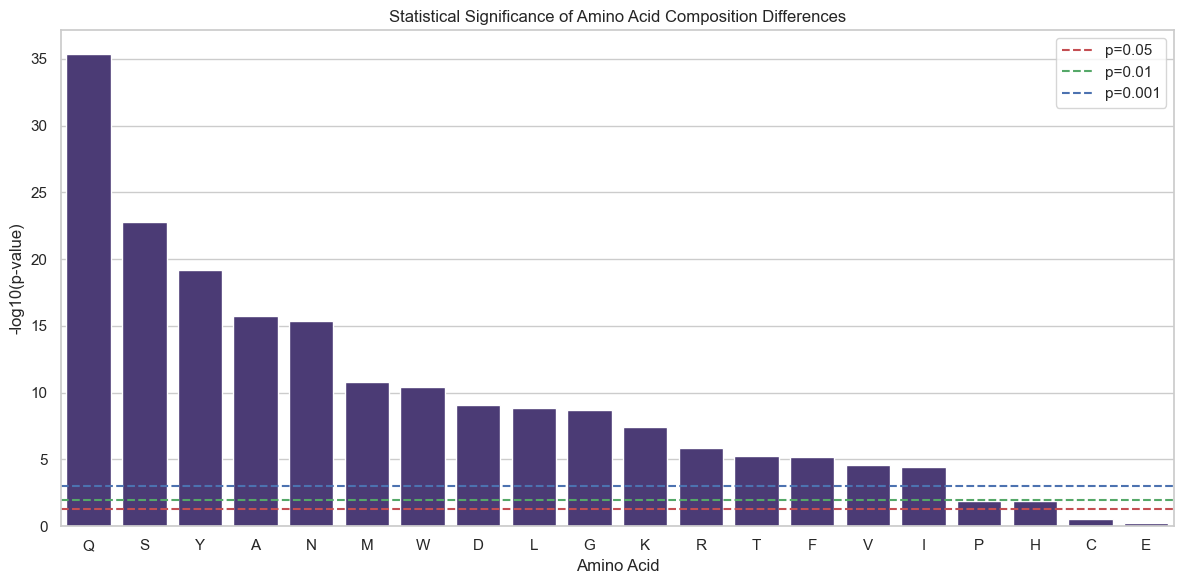

In [26]:
def analyze_amino_acid_composition(data):
    """
    Analyze and visualize the amino acid composition of sequences.
    """
    if isinstance(data, dict):
        df = data['combined']
    else:
        df = data
    
    # Define standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    
    # Function to calculate amino acid composition
    def calculate_aa_composition(sequence):
        seq_len = len(sequence)
        composition = {aa: sequence.count(aa) / seq_len * 100 for aa in amino_acids}
        return composition
    
    # Sample a subset for faster computation if dataset is large
    if len(df) > 10000:
        print("Sampling 10,000 sequences for amino acid composition analysis...")
        sample_df = df.sample(10000, random_state=42)
    else:
        sample_df = df
    
    # Calculate amino acid composition for each sequence
    print("Calculating amino acid composition...")
    compositions = []
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        comp = calculate_aa_composition(row['VHH_sequence'])
        comp['label'] = row['label']
        compositions.append(comp)
    
    # Convert to DataFrame
    comp_df = pd.DataFrame(compositions)
    
    # Calculate average composition by class
    avg_comp_by_class = comp_df.groupby('label').mean()
    
    # Plot average amino acid composition by class
    plt.figure(figsize=(14, 8))
    
    # Reshape for plotting
    avg_comp_melted = avg_comp_by_class.reset_index().melt(id_vars='label', 
                                                          value_vars=list(amino_acids),
                                                          var_name='Amino Acid',
                                                          value_name='Percentage')
    avg_comp_melted['label'] = avg_comp_melted['label'].map({0: 'Non-binders', 1: 'Binders'})
    
    # Plot
    sns.barplot(data=avg_comp_melted, x='Amino Acid', y='Percentage', hue='label', palette=['skyblue', 'salmon'])
    plt.title('Average Amino Acid Composition by Binding Class')
    plt.xlabel('Amino Acid')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'aa_composition_by_class.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical test for each amino acid
    print("\nStatistical tests for amino acid composition differences:")
    p_values = {}
    for aa in amino_acids:
        binders = comp_df[comp_df['label'] == 1][aa]
        non_binders = comp_df[comp_df['label'] == 0][aa]
        
        t_stat, p_value = stats.ttest_ind(binders, non_binders, equal_var=False)
        p_values[aa] = p_value
        
        if p_value < 0.05:
            significance = "*"
            if p_value < 0.01:
                significance = "**"
            if p_value < 0.001:
                significance = "***"
            
            print(f"{aa}: p-value = {p_value:.4f} {significance} (Mean in binders: {binders.mean():.2f}%, Mean in non-binders: {non_binders.mean():.2f}%)")
    
    # Plot p-values
    plt.figure(figsize=(12, 6))
    p_values_series = pd.Series(p_values)
    p_values_series = -np.log10(p_values_series)
    p_values_series = p_values_series.sort_values(ascending=False)
    
    sns.barplot(x=p_values_series.index, y=p_values_series.values)
    plt.title('Statistical Significance of Amino Acid Composition Differences')
    plt.xlabel('Amino Acid')
    plt.ylabel('-log10(p-value)')
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
    plt.axhline(y=-np.log10(0.01), color='g', linestyle='--', label='p=0.01')
    plt.axhline(y=-np.log10(0.001), color='b', linestyle='--', label='p=0.001')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'aa_composition_pvalues.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Analyze amino acid composition
analyze_amino_acid_composition(data)

## 5. Summary of Initial Findings

Based on our initial exploratory data analysis, we can summarize the following key findings about the AVIDa-SARS-CoV-2 dataset:

1. **Dataset Size and Structure**:
   - The dataset contains a substantial number of antibody sequences with binary binding labels
   - The data is split into training and test sets, with consistent features across both

2. **Class Distribution**:
   - There is a class imbalance with more non-binding than binding antibodies
   - This imbalance will need to be addressed during model training through techniques like class weighting or resampling

3. **Sequence Properties**:
   - Antibody sequences have a relatively consistent length distribution
   - Any significant differences in sequence length between binders and non-binders could be an important feature

4. **Antigen Variants**:
   - The dataset includes multiple SARS-CoV-2 variants
   - Binding rates vary across variants, which could be important for model generalization

5. **Donor Characteristics**:
   - All sequences come from alpaca donors
   - Different donors show varying binding rates, suggesting donor-specific factors

6. **Amino Acid Composition**:
   - Certain amino acids show statistically significant differences in frequency between binding and non-binding antibodies
   - These differences can be leveraged as features for our predictive models

These findings will inform our feature engineering approach and model development strategy in subsequent notebooks.

## 6. Next Steps

Based on our initial exploration, the next steps in our analysis will include:

1. **Data Preprocessing and Cleaning**:
   - Handle any invalid amino acid codes or outliers
   - Address class imbalance through appropriate techniques
   - Split data into training, validation, and test sets

2. **Feature Engineering**:
   - Extract sequence-based features (amino acid composition, dipeptide composition)
   - Calculate physicochemical properties (hydrophobicity, charge, etc.)
   - Identify structural propensities and binding-related features

3. **Model Development**:
   - Implement baseline models
   - Develop and tune more advanced models
   - Evaluate and compare model performance

4. **Results Analysis and Interpretation**:
   - Analyze feature importance
   - Interpret model predictions in biological context
   - Identify potential improvements and future work